I have discovered a strategy which will make ArchiCapital
the biggest trading company ever. Here's how my thesis goes,

t: Timestamp
St: Voucher Underlying Price at t
K: Strike
TTE: Remaining Time till expiry at t
Vt: Voucher price of strike K at t

Compute,

m_t = log(K/St)/ sqrt(TTE)

v_t = BlackScholes ImpliedVol(St, Vt, K, TTE)

for each t, plot v_t vs m_t and fit a parabolic curve to filter random noise.

This fitted v_t(m_t) allows me to evaluate opportunities between different strikes.
I also call fitted v_t(m_t=0) the base IV and I have identified interesting patterns in timeseries of base IV.

In [ ]:
from math import log, sqrt
from statistics import NormalDist

def black_scholes_call(spot, strike, time_to_expiry, volatility):
        d1 = (log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry) / (volatility * sqrt(time_to_expiry))
        d2 = d1 - volatility * sqrt(time_to_expiry)
        call_price = spot * NormalDist().cdf(d1) - strike * NormalDist().cdf(d2)
        return call_price

def implied_volatility(call_price, spot, strike, time_to_expiry, max_iterations=200, tolerance=1e-10):
        low_vol = 0.01
        high_vol = 1.0
        volatility = (low_vol + high_vol) / 2.0  # Initial guess as the midpoint
        # binary search ts
        for _ in range(max_iterations):
            estimated_price = black_scholes_call(spot, strike, time_to_expiry, volatility)
            diff = estimated_price - call_price
            if abs(diff) < tolerance:
                break
            elif diff > 0:
                high_vol = volatility
            else:
                low_vol = volatility
            volatility = (low_vol + high_vol) / 2.0
        return volatility

In [2]:
# initial data read

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# merge all days together
df = pd.concat([
    pd.read_csv(f'data/prices_round_3_day_0.csv', sep=';'),
    pd.read_csv(f'data/prices_round_3_day_1.csv', sep=';'),
    pd.read_csv(f'data/prices_round_3_day_2.csv', sep=';')
], ignore_index=True)
df['timestamp'] += 1000000 * df['day']

# only keep the relevant columns
df = df[['day', 'timestamp', 'product', 'mid_price']]

In [15]:
# split data per each voucher and compute m_t and v_t

vouchers = ['VOLCANIC_ROCK_VOUCHER_9500', 'VOLCANIC_ROCK_VOUCHER_9750', 'VOLCANIC_ROCK_VOUCHER_10000', 'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500']

spot_prices = df[df['product'] == 'VOLCANIC_ROCK'][['timestamp', 'mid_price']].rename(columns={'mid_price': 'spot_price'})
voucher_dfs = {}

round_num = 3

for voucher in vouchers:
    strike = int(voucher.split('_')[-1])
    
    voucher_df = df[df['product'] == voucher][['timestamp', 'mid_price']]
    voucher_df = voucher_df.merge(spot_prices, on='timestamp', how='left')
    
    voucher_df['tte'] = (8 - round_num) - (voucher_df['timestamp'] / 1000000) / 30
    
    # m_t = log(K / St) / sqrt(TTE)
    voucher_df['m_t'] = np.log(strike / voucher_df['spot_price']) / np.sqrt(voucher_df['tte'])
    
    # v_t = BlackScholes.ImpliedVol(St, Vt, K, TTE)
    voucher_df['v_t'] = voucher_df.apply(lambda row: implied_volatility(row['mid_price'], row['spot_price'], strike, row['tte']), axis=1)
    
    voucher_dfs[voucher] = voucher_df
    
    voucher_df.to_csv(f'data/voucher_{strike}.csv', sep=';', index=False)


[-1.64406275 -0.27438962  0.00464026]


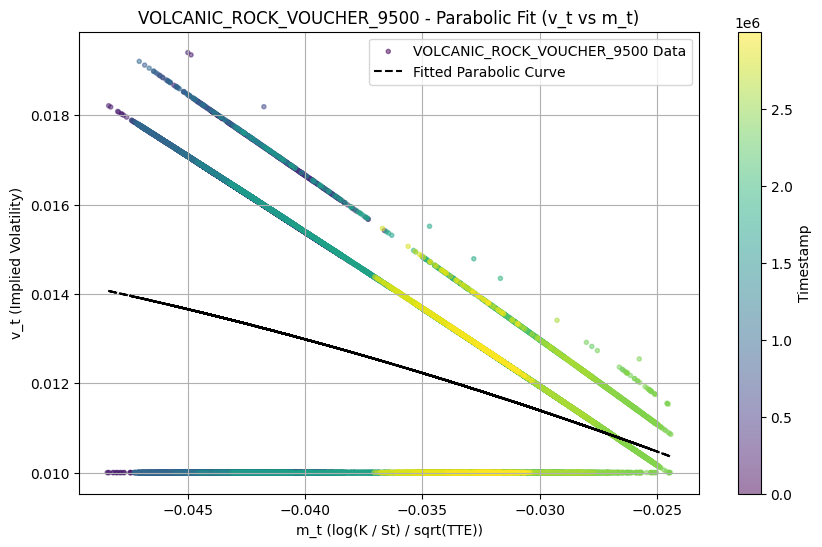

[4.0860304  0.02655925 0.00918263]


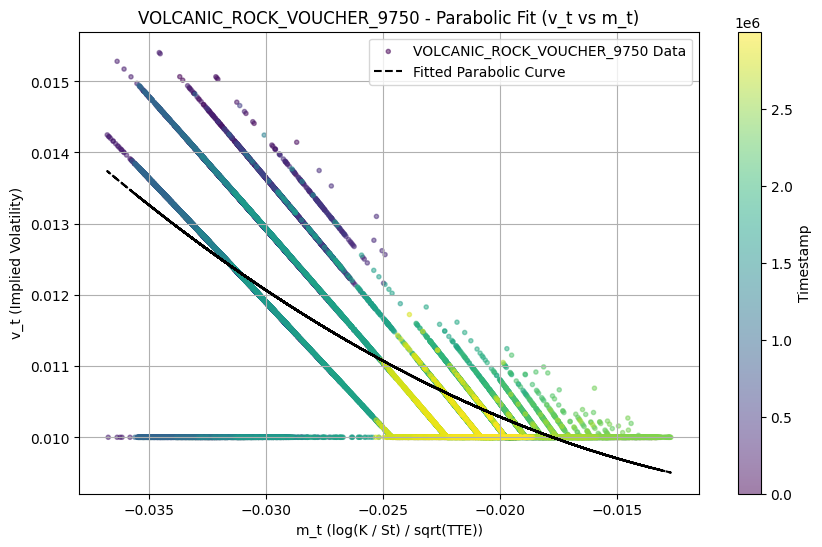

[4.33987917 0.05387251 0.01013437]


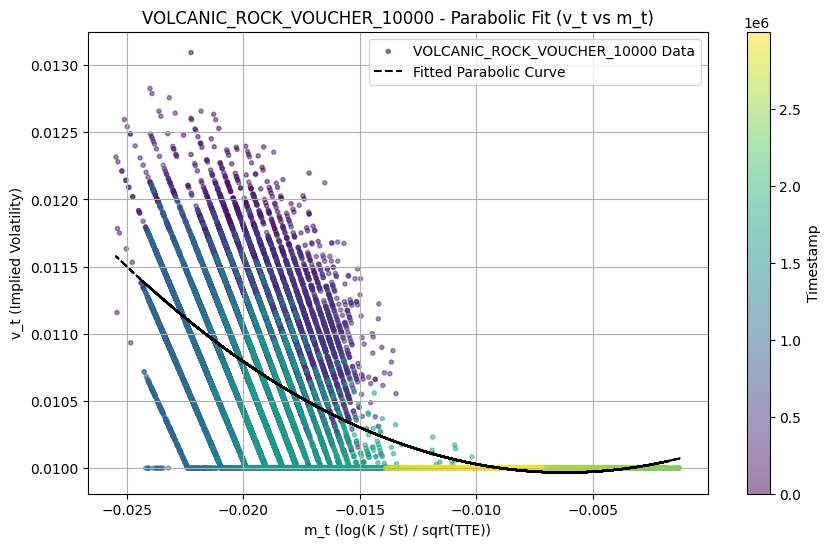

[ 0.44974245 -0.00481083  0.01000866]


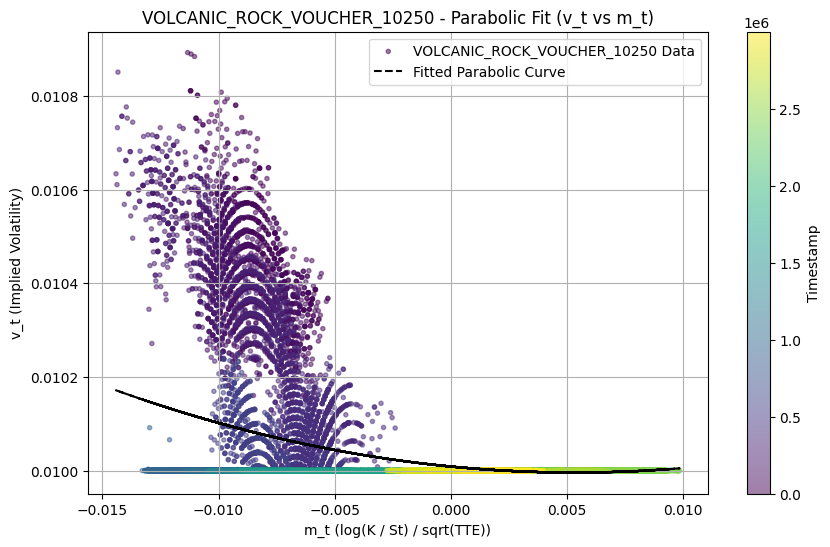

[ 0.0308804  -0.00287238  0.01003948]


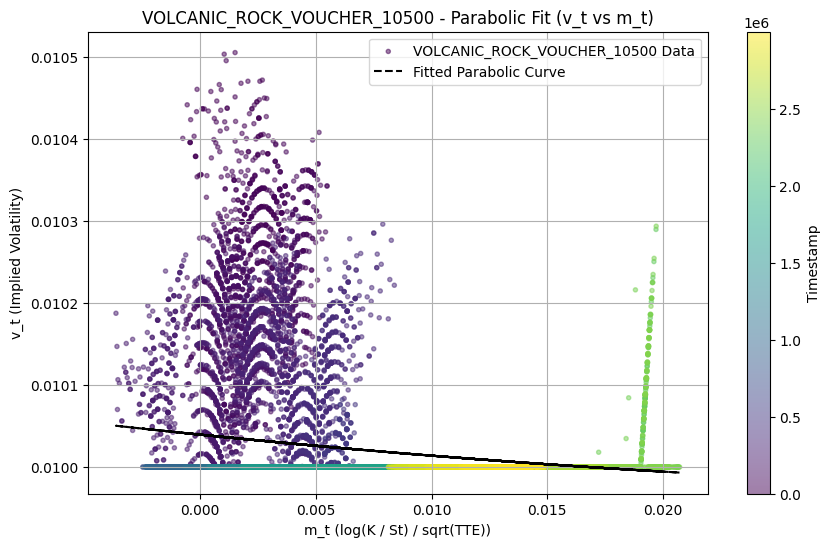

In [13]:
# Define the function for plotting and fitting
def plot_and_fit(voucher_df, voucher, strike):
    # Scatter plot of v_t vs m_t
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(voucher_df['m_t'], voucher_df['v_t'], c=voucher_df['timestamp'], cmap='viridis', label=f'{voucher} Data', marker='.', alpha=0.5)
    plt.colorbar(scatter, label='Timestamp')
    
    # Fit a parabolic (quadratic) curve to the data
    # We will use np.polyfit to fit a 2nd degree polynomial
    # polyfit returns the coefficients (a, b, c) of the quadratic equation ax^2 + bx + c
    coefficients = np.polyfit(voucher_df['m_t'], voucher_df['v_t'], 2)
    print(coefficients)
    # Create the fitted curve using the coefficients
    fitted_curve = np.polyval(coefficients, voucher_df['m_t'])
    
    # Plot the fitted parabolic curve
    plt.plot(voucher_df['m_t'], fitted_curve, label='Fitted Parabolic Curve', color='k', linestyle='--')
    
    # Labels and title
    plt.title(f'{voucher} - Parabolic Fit (v_t vs m_t)')
    plt.xlabel('m_t (log(K / St) / sqrt(TTE))')
    plt.ylabel('v_t (Implied Volatility)')
    plt.legend()
    plt.grid(True)
    
    plt.savefig(f'results/{voucher}_hint.png')
    
    # Show the plot
    plt.show()

# Iterate over each voucher to plot and fit a curve
for voucher, voucher_df in voucher_dfs.items():
    strike = int(voucher.split('_')[-1])  # Extract the strike price from the voucher name
    plot_and_fit(voucher_df, voucher, strike)


[ 1.77106296 -0.007772    0.00987581]


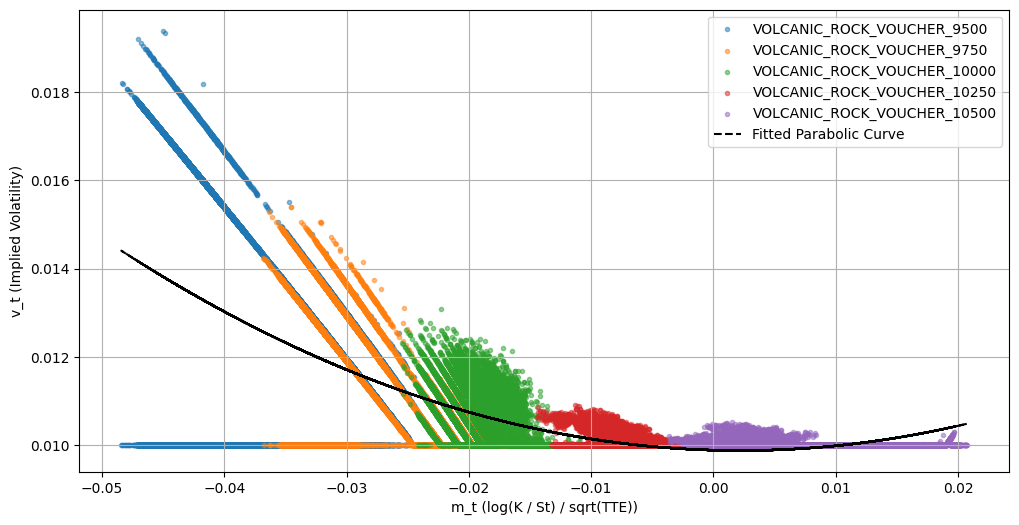

In [14]:
# merge all vouchers together
all_vouchers_df = pd.concat(voucher_dfs.values(), ignore_index=True)

# Fit a parabolic (quadratic) curve to the data
coefficients = np.polyfit(all_vouchers_df['m_t'], all_vouchers_df['v_t'], 2)
print(coefficients)
# Create the fitted curve using the coefficients
fitted_curve = np.polyval(coefficients, all_vouchers_df['m_t'])

# Scatter plot of v_t vs m_t for all vouchers
plt.figure(figsize=(12, 6))

for voucher, voucher_df in voucher_dfs.items():
    scatter = plt.scatter(voucher_df['m_t'], voucher_df['v_t'], label=voucher, marker='.', alpha=0.5)

# Plot the fitted parabolic curve
plt.plot(all_vouchers_df['m_t'], fitted_curve, label='Fitted Parabolic Curve', color='k', linestyle='--')

plt.xlabel('m_t (log(K / St) / sqrt(TTE))')
plt.ylabel('v_t (Implied Volatility)')
plt.legend()
plt.grid(True)

plt.show()